# Monte Carlo with Gridworld

## Goal:

- How to implement Monte Carlo algorithm
- understandig caveats in RL

In [1]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Make Env

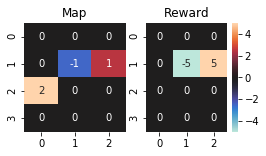

In [2]:
def make_env():
    env = rl.env.Gridworld(shape=(4, 3),
                           start=(2, 0),
                           goal=(1, 2),
                           move_reward=-1)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=20)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env


env = make_env()
env.reset()
env.render()

## Step 2: Define policy

First-visit Monte Carlo + Policy iteration + Epsilon greedy

### Helper functions

In [3]:
def calculate_return(r, discount_factor):
    """return G for every time step given a sequence of rewards"""
    # code here ...
    # ...
    n = len(r)
    g = np.zeros(r.shape)
    current = 0
    for i in reversed(range(0, n)):
        current = r[i] + current * discount_factor
        g[i] = current
    return g

Test calculating return:

In [4]:
calculate_return(np.array([1., 1., 1., 1.]), 0.9)

array([3.439, 2.71 , 1.9  , 1.   ])

Expected result:

```
array([3.439, 2.71 , 1.9  , 1.   ])
```

In [5]:
def first_sa(s, a, g):
    """deduplicate (s, a) keeping only the first occurrances while also matching the corresponding returns"""
    # code here ...
    # ...
    a = np.expand_dims(a, 1)
    sa = np.hstack((s, a))
    sa, i = np.unique(sa, return_index=True, axis=0)
    sa = (sa[:, 0], sa[:, 1], sa[:, 2])
    g = g[i]
    # return unique sa and g
    # sa = tuple(first dim of s, second dim of s, a)
    # this is for numpy indexing!
    # ex: sa = ([0, 0], [0, 1], [1, 1])
    # means: s = [(0, 0), (0, 1)]; a = [1, 1]
    return sa, g 

Test first_sa:

In [6]:
s = np.array([
    [0, 0],
    [0, 1],
    [0, 0],
])
a = np.array([1, 1, 1])
g = np.array([1, 2, 3])
sa, g = first_sa(s, a, g)
print('sa:', sa)
print('g:', g)

sa: (array([0, 0]), array([0, 1]), array([1, 1]))
g: [1 2]


Expected result:

```
sa: (array([0, 0]), array([0, 1]), array([1, 1]))
g: [1 2]
```

Note: The third state and action in sequence is a duplicate. Discarded.

### The policy: First-visit Monte Carlo with True Average

Note: there are many variants of MC, including:

- first or all visits
- true average or moving average

Here we concern ourselves with first-visit MC with true average

In [7]:
class MonteCarloPolicy(rl.policy.BasePolicy):
    """firt visit monte carlo with true average"""

    def __init__(self, discount_factor, observation_space, n_action):
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        # value tables
        self.q = np.zeros(list(self.observation_space.high) +
                          [n_action])  # (s0, s1, a)
        self.cnt = np.zeros(self.q.shape, dtype=int)

    def step(self, state):
        return np.argmax(self.q[tuple(state)])  # greedy action selection

    def optimize_step(self, data):
        """update the action value (q) table with MC algorithm"""
        s = np.array(data['s'])
        a = np.array(data['a'])
        r = np.array(data['r'])
        
        # code here ...
        # ...
        g = calculate_return(r, self.discount_factor)
        sa, g = first_sa(s, a, g)
        error = g - self.q[sa]
        self.cnt[sa] += 1
        self.q[sa] += 1 / self.cnt[sa] * error

## Step 3: Define an explorer

In [8]:
policy = MonteCarloPolicy(discount_factor=0.99,
                          observation_space=env.observation_space,
                          n_action=env.action_space.n)

max: -20


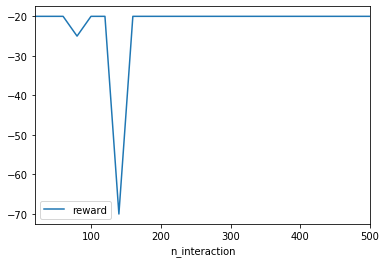

In [9]:
def run(policy, n_max_interaction):
    rl.util.set_seed(0) # predictable results
    env = make_env()
    explorer = rl.explorer.EpisodeExplorer(n_max_interaction=n_max_interaction, env=env)

    while True:
        try:
            data = explorer.step(policy)
            policy.optimize_step(data)  # not defined
        except rl.exception.InteractionExceeded:
            break
    df = pd.DataFrame(explorer.get_stats()['history'])
    return df
    
stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Expected result: Bad rewards (some -20 reward)

# Q1: Why we can't seem to learn a good policy?

describe here ...

Answer: we forgot to explore.

# Q2: Make changes to make the algorithm learn as expected

Hint: make the policy more random by adding a random wrapper on top of it 😉

In [12]:
class Wrapper(rl.policy.BasePolicyWrapper):
    """wraps around the policy to give the original policy some randomness"""
    def __init__(self, policy):
        self.policy = policy

    def step(self, state):
        # code here ...
        # ...
        if random.random() < 0.1:
            return random.randint(0, 3)
        else:
            return self.policy.step(state)

Test again:

max: 2


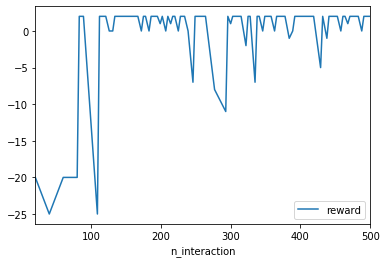

In [11]:
policy = MonteCarloPolicy(discount_factor=0.99,
                          observation_space=env.observation_space,
                          n_action=env.action_space.n)
policy = Wrapper(policy)


stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Expected result: You should get max reward close to 2 (much better than previously -21). If not you might want to tune your randomness.

# Q3: What is the theoretically maximum reward we could get under this setting with an optimal policy?

Describe here ...

answer: 2 because the reward is 5 we need to take 3 actions before getting there incurring -3 rewards.

# Q4: What will happen in terms of learning if we change the move reward from -1 to 0? Why?

That is each move will not be penalized anymore.

Describe here ...

Answer: it learns much much slower (5000 itr to see the difference) because there will be no learning until we sample a trajectory that passes the goal state which chance is slim. When we have -1 for each step at least it encourages the agent to explore to where it has not yet visited because the value table initialized to be 0 which is higher than -1.

# Q6: After changing move reward to 0 what is now the theoretically maximum reward attainable?

Describe here: ...

Answer: 5, there is no more negative rewards.

# Q7: What would happen in terms of learning if we don't clip the episode?

Describe here ...

Answer: the training would be very slow, much much slower.